# Fold assignments

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

def generate_nested_cv_folds(ids, labels, outer_n=5, inner_n=4, random_state=42, shuffle=True, verbose=True):
    """ 
    Generates nested cross-validation folds with ID-label pairs.
    """
    ids = np.array(ids)
    labels = np.array(labels)

    if verbose:
        print("Generating fold assignments...")
        print(f"=== Nested CV ({outer_n}-outer, {inner_n}-inner) ===")
        print(f"Random state: {random_state} | Shuffle: {shuffle}\n")
        print(f"HC: {(labels == 0).sum()}, PD: {(labels == 1).sum()}")

    folds = {}
    outer_cv = StratifiedKFold(n_splits=outer_n, shuffle=shuffle, random_state=random_state)

    for outer_idx, (train_idx, test_idx) in enumerate(outer_cv.split(ids, labels), 1):
        train_ids, test_ids = ids[train_idx], ids[test_idx]
        train_labels, test_labels = labels[train_idx], labels[test_idx]

        if verbose:
            print(f"Outer Fold {outer_idx}/{outer_n}")
            print(f"Train: {len(train_ids)} | Test: {len(test_ids)}\n")

        outer_fold = {
            "test": {id_: int(label) for id_, label in zip(test_ids, test_labels)},
            "inner": {}
        }

        inner_cv = StratifiedKFold(n_splits=inner_n, shuffle=shuffle, random_state=outer_idx)
        for inner_idx, (inner_train_idx, val_idx) in enumerate(inner_cv.split(train_ids, train_labels), 1):
            inner_train_ids = train_ids[inner_train_idx]
            inner_train_labels = train_labels[inner_train_idx]
            val_ids = train_ids[val_idx]
            val_labels = train_labels[val_idx]

            outer_fold["inner"][inner_idx] = {
                "train": {id_: int(label) for id_, label in zip(inner_train_ids, inner_train_labels)},
                "val": {id_: int(label) for id_, label in zip(val_ids, val_labels)}
            }

        folds[outer_idx] = outer_fold

    return folds

def generate_folds_from_classes(metadata_file, class_pair, output_file, exclude_id="C037_BFL"):
    # Load metadata and exclude unwanted ID
    metadata = pd.read_csv(metadata_file)
    metadata = metadata[metadata['ID'] != exclude_id]

    # Filter only the desired class2 values
    metadata = metadata[metadata['class2'].isin(class_pair)]

    # Map the classes to 0 and 1
    label_map = {class_pair[0]: 0, class_pair[1]: 1}
    metadata['class2'] = metadata['class2'].map(label_map)

    # Drop any rows with missing values
    metadata = metadata.dropna()
    metadata['class2'] = metadata['class2'].astype(int)

    # Get ids and labels
    ids = metadata['ID'].tolist()
    labels = metadata['class2'].tolist()

    # Generate nested folds
    fold_dict = generate_nested_cv_folds(ids, labels, outer_n=5, inner_n=4, random_state=42, shuffle=True)

    # Save to JSON
    with open(output_file, "w") as f:
        json.dump(fold_dict, f, indent=4)

    print(f"Saved folds to {output_file}")

# Settings
outer_n = 5
inner_n = 4
random_state = 42
shuffle = True

metadata = pd.read_csv('metadata.csv')
metadata = metadata[metadata['ID'] != 'C037_BFL']
ids = metadata['ID'].to_list()
labels = metadata['class'].to_list() # 0 = HC, 1 = PD

fold_dict = generate_nested_cv_folds(ids, labels, outer_n=5, inner_n=4, random_state=42, shuffle=True)

import json
with open("folds/PD_vs_HC_folds.json", "w") as f:
    json.dump(fold_dict, f, indent=4)

Generating fold assignments...
=== Nested CV (5-outer, 4-inner) ===
Random state: 42 | Shuffle: True

HC: 39, PD: 40
Outer Fold 1/5
Train: 63 | Test: 16

Outer Fold 2/5
Train: 63 | Test: 16

Outer Fold 3/5
Train: 63 | Test: 16

Outer Fold 4/5
Train: 63 | Test: 16

Outer Fold 5/5
Train: 64 | Test: 15



In [2]:
def split_features(metadata_file, class_pair, features_file, output_file, exclude_id="C037_BFL"):
    import pandas as pd
    
    # Load metadata and exclude unwanted ID
    metadata = pd.read_csv(metadata_file)
    metadata = metadata[metadata['ID'] != exclude_id]

    # Filter only the desired class2 values
    metadata = metadata[metadata['class2'].isin(class_pair)]

    ids = metadata['ID'].tolist()
    ids = [f'{id}_MOTOR_LIBRE.wav' for id in ids]

    # Read the original CSV file
    df = pd.read_csv(features_file)

    df = df[df['id'].isin(ids)]

    # Filter rows based on the starting characters of the 'id' column
    df_hc = df[df['id'].str.startswith('C0')].copy()
    df_pd = df[df['id'].str.startswith('P0')].copy()

    print(df_hc)
    # Rename the column 'id' to 'ID'
    df_hc.rename(columns={'id': 'ID'}, inplace=True)
    df_pd.rename(columns={'id': 'ID'}, inplace=True)

    # Save to new CSV files
    df_hc.to_csv(f"{output_file}_HC.csv", index=False)
    df_pd.to_csv(f"{output_file}_PD.csv", index=False)

In [3]:
split_features(
    metadata_file='metadata.csv',
    class_pair=['CTR_DCL', 'Park_DCL'],
    features_file='features_motor_libre/phonologicalfeatures_ML.csv',
    output_file='phonologicalfeatures_ML'
)

    vocalic_mean  vocalic_std  vocalic_skewness  vocalic_kurtosis  \
0       0.385483     0.567479          0.798116          1.837927   
2       0.363856     0.702047          0.610329          0.133752   
4       0.377797     0.711579          0.713721         -0.221752   
5       0.399374     0.719585          0.635354         -0.260545   
6       0.254832     0.627154          0.838350          0.493202   
8       0.234391     0.641956          0.845168          0.323375   
10      0.316120     0.713778          0.885071          0.309897   
11      0.495519     0.972628          0.337222         -0.911865   
14      0.629089     0.674527          0.292874         -0.022010   
16      0.283633     0.697820          1.015909          0.828674   
17      0.280052     0.557543          0.970012          0.608728   
28      0.280873     0.657344          1.042032          0.903983   
29      0.330209     0.801703          0.596002         -0.365981   
35      0.337277     0.702621     

In [4]:
generate_folds_from_classes(
    metadata_file='metadata.csv',
    class_pair=['CTR_DCL', 'Park_DCL'],
    output_file='folds/CTR_DCL_vs_Park_DCL_folds.json'
)

generate_folds_from_classes(
    metadata_file='metadata.csv',
    class_pair=['CTR_noDCL', 'Park_noDCL'],
    output_file='folds/CTR_noDCL_vs_Park_noDCL_folds.json'
)

generate_folds_from_classes(
    metadata_file='metadata.csv',
    class_pair=['Park_noDCL', 'Park_DCL'],
    output_file='folds/Park_noDCL_vs_Park_DCL_folds.json'
)

Generating fold assignments...
=== Nested CV (5-outer, 4-inner) ===
Random state: 42 | Shuffle: True

HC: 16, PD: 16
Outer Fold 1/5
Train: 25 | Test: 7

Outer Fold 2/5
Train: 25 | Test: 7

Outer Fold 3/5
Train: 26 | Test: 6

Outer Fold 4/5
Train: 26 | Test: 6

Outer Fold 5/5
Train: 26 | Test: 6

Saved folds to folds/CTR_DCL_vs_Park_DCL_folds.json
Generating fold assignments...
=== Nested CV (5-outer, 4-inner) ===
Random state: 42 | Shuffle: True

HC: 23, PD: 24
Outer Fold 1/5
Train: 37 | Test: 10

Outer Fold 2/5
Train: 37 | Test: 10

Outer Fold 3/5
Train: 38 | Test: 9

Outer Fold 4/5
Train: 38 | Test: 9

Outer Fold 5/5
Train: 38 | Test: 9

Saved folds to folds/CTR_noDCL_vs_Park_noDCL_folds.json
Generating fold assignments...
=== Nested CV (5-outer, 4-inner) ===
Random state: 42 | Shuffle: True

HC: 24, PD: 16
Outer Fold 1/5
Train: 32 | Test: 8

Outer Fold 2/5
Train: 32 | Test: 8

Outer Fold 3/5
Train: 32 | Test: 8

Outer Fold 4/5
Train: 32 | Test: 8

Outer Fold 5/5
Train: 32 | Test: 8


# Running nested-CV

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from scipy.stats import expon
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, recall_score, precision_score

def specificity_score(y_true, y_pred):
    """Calculate specificity (true negative rate)"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def train_inner_model(X_train, y_train, inner_folds, random_state):
    """Train model with inner CV grid search"""
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(probability=True, random_state=random_state))
    ])
    
    # kernel lineal
    param_grid = {
        'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
        'kernel': ['rbf']
    }
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=inner_folds,
        scoring='f1', # accuracy
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

def train_randomized_inner_model(X_train, y_train, inner_folds, random_state, n_iter=1000):
    """Train model with inner CV grid search"""
    
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    
    # kernel lineal
    param_grid = {
        'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
        'kernel': ['rbf']
    }
    
    svc1=SVC(random_state=random_state)
    grid_search = GridSearchCV(
        svc1,
        param_grid,
        cv=inner_folds,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)

    best_C = grid_search.best_params_['C']
    best_gamma = grid_search.best_params_['gamma']

    print("Initial best C from GridSearch:", best_C)
    print("Initial best gamma from GridSearch:", best_gamma)

    param_distributions = {
        'C': expon(scale=best_C),
        'gamma': expon(scale=best_gamma),
        'kernel': ['rbf']
    }
    
    svc=SVC(random_state=random_state)
    random_search = RandomizedSearchCV(
        svc,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=inner_folds,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1,
        random_state=random_state
    )

    random_search.fit(X_train, y_train)
    
    print("Final best params from RandomizedSearch:")
    print(random_search.best_params_)
    print("Final best score:", random_search.best_score_)

    return random_search

def evaluate_model(model, X_test, y_test):
    """Evaluate model and return metrics"""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'sensitivity': recall_score(y_test, y_pred),
        'specificity': specificity_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'y_true': y_test,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

def plot_ROC_curve(all_y_true, all_y_proba, filename='roc_curve.png'):
    """Generate and save ROC curve"""

    fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.close()

def plot_confusion_matrix(all_y_true, all_y_pred, filename='confusion_matrix.png'):
    """Generate and save confusion matrix"""

    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_matrix(all_y_true, all_y_pred), 
                annot=True, fmt='d', cmap='Blues',
                xticklabels=['HC', 'PD'],
                yticklabels=['HC', 'PD'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(filename)
    plt.close()

def plot_probability_density(y_true, y_proba, filename='probability_density.png'):
    """
    Plot density distribution of predicted probabilities for each class
    
    Parameters:
    -----------
    y_true : array-like
        True labels (0=HC, 1=PD)
    y_proba : array-like
        Predicted probabilities for class 1 (PD)
    save_path : str
        Path to save the plot
    """
    # Create DataFrame for plotting
    df = pd.DataFrame({
        'Probability': y_proba,
        'Group': ['HC' if label == 0 else 'PD' for label in y_true]
    })
    
    # Define colors (Soft blue shades)
    blues = sns.color_palette("Blues", n_colors=6)
    colors = [blues[1], blues[4]]  # light blue for HC, dark blue for PD

    # Create figure with two subplots: Boxplot (top) and Density plot (bottom)
    fig, axes = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios': [1, 4]}, figsize=(6, 6), sharex=True)

    # Boxplot (Top)
    sns.boxplot(x="Probability", y="Group", data=df, dodge=False, palette=colors, ax=axes[0])
    axes[0].set_xlabel("")  # Remove xlabel to avoid redundancy
    axes[0].set_ylabel("")
    axes[0].set_yticks([])
    axes[0].set_title("Predicted Probability Distribution")

    # Histogram + KDE (Bottom)
    sns.histplot(data=df, x="Probability", hue="Group", kde=True, palette=colors, stat="density", bins=20, ax=axes[1], legend=True)
    
    axes[1].set_xlabel("Predicted Probability")
    legend_handles = [
        Patch(color=colors[0], label='HC'),
        Patch(color=colors[1], label='PD')
    ]
    axes[1].legend(handles=legend_handles)
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300)  # Save the plot
    plt.close()

def run_nested_svm_cv(fold_dict, features_df, random_state=42, features='articulation'):
    """
        Perform nested CV SVM classification with predefined folds
        
        Parameters:
        -----------
        fold_dict : dict
            Output from generate_nested_cv_folds()
        features_df : pd.DataFrame
            DataFrame with features (index=filename, columns=features)
        random_state : int
            Random seed for reproducibility
            
        Returns:
        --------
        tuple: (results_df, all_y_true, all_y_pred, all_y_proba)
    """
    results = []
    all_y_true = []
    all_y_pred = []
    all_y_proba = []

    for outer_fold, fold_info in fold_dict.items():
        test_ids = [id_ + '_MOTOR_LIBRE.wav' for id_ in fold_info["test"].keys()]
        y_test = list(fold_info["test"].values())

        train_labels_dict = {}
        for inner in fold_info["inner"].values():
            train_labels_dict.update(inner["train"])
            train_labels_dict.update(inner["val"])
        train_ids = [id_ + '_MOTOR_LIBRE.wav' for id_ in train_labels_dict.keys()]
        y_train = list(train_labels_dict.values())

        X_train = features_df.loc[train_ids].values
        X_test = features_df.loc[test_ids].values

        inner_folds = []
        for inner_num, inner in fold_info["inner"].items():
            inner_train_ids = [id_ + '_MOTOR_LIBRE.wav' for id_ in inner["train"].keys()]
            val_ids = [id_ + '_MOTOR_LIBRE.wav' for id_ in inner["val"].keys()]
            train_idx = [i for i, id_ in enumerate(train_ids) if id_ in inner_train_ids]
            val_idx = [i for i, id_ in enumerate(train_ids) if id_ in val_ids]
            inner_folds.append((train_idx, val_idx))

        model = train_inner_model(X_train, y_train, inner_folds, random_state)
        metrics = evaluate_model(model, X_test, y_test)

        results.append({
            'outer_fold': outer_fold,
            **metrics,
            'best_params': model.get_params()['svm'],
            'train_files': train_ids,
            'test_files': test_ids
        })

        all_y_true.extend(metrics['y_true'])
        all_y_pred.extend(metrics['y_pred'])
        all_y_proba.extend(metrics['y_proba'])

        print(f"\nFold {outer_fold} Results:")
        print(f"Train set size: {len(y_train)}")
        print(f"Test set size: {len(y_test)}")
        print(f"Accuracy: {metrics['accuracy']:.3f}")
        print(f"Sensitivity: {metrics['sensitivity']:.3f}")
        print(f"Specificity: {metrics['specificity']:.3f}")

    plot_ROC_curve(all_y_true, all_y_proba, f'results_motor_libre/plots/roc_curve_{features}.png')
    plot_confusion_matrix(all_y_true, all_y_pred, f'results_motor_libre/plots/confusion_matrix_{features}.png')
    plot_probability_density(all_y_true, all_y_proba, f'results_motor_libre/plots/probability_density_{features}.png')

    return results, np.array(all_y_true), np.array(all_y_pred), np.array(all_y_proba)

# All features

In [6]:
feature_sets = {
    'articulation': ['articulationfeatures_ML.csv'],
    'phonation': ['phonationfeatures_ML.csv'],
    'phonological': ['phonologicalfeatures_ML.csv'],
    'prosody': ['prosodyfeatures_ML.csv'],
    'all': [
        'articulationfeatures_ML.csv',
        'phonationfeatures_ML.csv',
        'phonologicalfeatures_ML.csv',
        'prosodyfeatures_ML.csv'
    ]
}

with open("folds/PD_vs_HC_folds.json", "r") as f:
    fold_dict = json.load(f)

# Loop over each feature set
for feature_name, file_list in feature_sets.items():
    print(f"\n=== Running Nested CV for: {feature_name} ===")

    # Load and combine features
    features_df = pd.concat([
        pd.read_csv(f'features_motor_libre/{f}').set_index('id') for f in file_list
    ], axis=1)

    print(f"Feature shape: {features_df.shape}")

    # Run nested CV
    results, _, _, _ = run_nested_svm_cv(fold_dict, features_df, features=feature_name)

    # Save results
    results_df = pd.DataFrame(results)
    results_df.to_csv(f'results_motor_libre/{feature_name}_results.csv', index=False)

    # Aggregate metrics
    final_metrics = {
        'mean_accuracy': np.mean([x['accuracy'] for x in results]),
        'std_accuracy': np.std([x['accuracy'] for x in results]),
        'mean_sensitivity': np.mean([x['sensitivity'] for x in results]),
        'std_sensitivity': np.std([x['sensitivity'] for x in results]),
        'mean_specificity': np.mean([x['specificity'] for x in results]),
        'std_specificity': np.std([x['specificity'] for x in results]),
        'mean_f1': np.mean([x['f1'] for x in results]),
        'std_f1': np.std([x['f1'] for x in results]),
    }

    # Print metrics
    print(f"\n=== Final Metrics {feature_name.title()} ===")
    print(f"Mean Accuracy: {100*final_metrics['mean_accuracy']:.1f} ± {100*final_metrics['std_accuracy']:.1f}")
    print(f"Mean Sensitivity: {100*final_metrics['mean_sensitivity']:.1f} ± {100*final_metrics['std_sensitivity']:.1f}")
    print(f"Mean Specificity: {100*final_metrics['mean_specificity']:.1f} ± {100*final_metrics['std_specificity']:.1f}")
    print(f"Mean f1: {100*final_metrics['mean_f1']:.1f} ± {100*final_metrics['std_f1']:.1f}")


=== Running Nested CV for: articulation ===
Feature shape: (85, 488)
Fitting 4 folds for each of 72 candidates, totalling 288 fits


ValueError: Invalid parameter 'C' for estimator Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(probability=True, random_state=42))]). Valid parameters are: ['memory', 'steps', 'verbose'].


=== Running Nested CV for: articulation ===
Fitting 4 folds for each of 49 candidates, totalling 196 fits

Fold 1 Results:
Train set size: 32
Test set size: 8
Accuracy: 0.625
Sensitivity: 1.000
Specificity: 0.400
Fitting 4 folds for each of 49 candidates, totalling 196 fits

Fold 2 Results:
Train set size: 32
Test set size: 8
Accuracy: 0.750
Sensitivity: 0.333
Specificity: 1.000
Fitting 4 folds for each of 49 candidates, totalling 196 fits

Fold 3 Results:
Train set size: 32
Test set size: 8
Accuracy: 0.750
Sensitivity: 0.667
Specificity: 0.800
Fitting 4 folds for each of 49 candidates, totalling 196 fits

Fold 4 Results:
Train set size: 32
Test set size: 8
Accuracy: 1.000
Sensitivity: 1.000
Specificity: 1.000
Fitting 4 folds for each of 49 candidates, totalling 196 fits

Fold 5 Results:
Train set size: 32
Test set size: 8
Accuracy: 0.625
Sensitivity: 0.250
Specificity: 1.000



KeyboardInterrupt



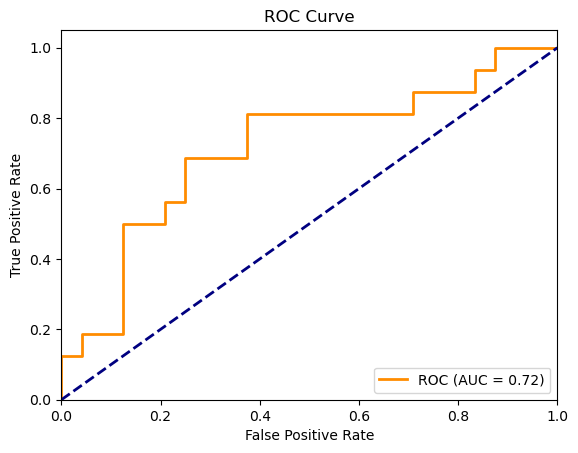

In [ ]:
feature_sets = {
    'articulation': ['articulationfeatures_ML.csv'],
    'phonation': ['phonationfeatures_ML.csv'],
    'phonological': ['phonologicalfeatures_ML.csv'],
    'prosody': ['prosodyfeatures_ML.csv'],
    'all': [
        'articulationfeatures_ML.csv',
        'phonationfeatures_ML.csv',
        'phonologicalfeatures_ML.csv',
        'prosodyfeatures_ML.csv'
    ]
}

with open("folds/Park_noDCL_vs_Park_DCL_folds.json", "r") as f:
    fold_dict = json.load(f)

# Loop over each feature set
for feature_name, file_list in feature_sets.items():
    print(f"\n=== Running Nested CV for: {feature_name} ===")

    # Load and combine features
    features_df = pd.concat([
        pd.read_csv(f'features_motor_libre/{f}').set_index('id') for f in file_list
    ], axis=1)

    # Run nested CV
    results, _, _, _ = run_nested_svm_cv(fold_dict, features_df, features=feature_name)

    # Save results
    results_df = pd.DataFrame(results)
    results_df.to_csv(f'results_motor_libre/{feature_name}_results.csv', index=False)

    # Aggregate metrics
    final_metrics = {
        'mean_accuracy': np.mean([x['accuracy'] for x in results]),
        'std_accuracy': np.std([x['accuracy'] for x in results]),
        'mean_sensitivity': np.mean([x['sensitivity'] for x in results]),
        'std_sensitivity': np.std([x['sensitivity'] for x in results]),
        'mean_specificity': np.mean([x['specificity'] for x in results]),
        'std_specificity': np.std([x['specificity'] for x in results]),
        'mean_f1': np.mean([x['f1'] for x in results]),
        'std_f1': np.std([x['f1'] for x in results]),
    }

    # Print metrics
    print(f"\n=== Final Metrics {feature_name.title()} ===")
    print(f"Mean Accuracy: {100*final_metrics['mean_accuracy']:.1f} ± {100*final_metrics['std_accuracy']:.1f}")
    print(f"Mean Sensitivity: {100*final_metrics['mean_sensitivity']:.1f} ± {100*final_metrics['std_sensitivity']:.1f}")
    print(f"Mean Specificity: {100*final_metrics['mean_specificity']:.1f} ± {100*final_metrics['std_specificity']:.1f}")
    print(f"Mean f1: {100*final_metrics['mean_f1']:.1f} ± {100*final_metrics['std_f1']:.1f}")

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline

def run_late_fusion_nested_cv(fold_info_dict, features_dict, random_state=42):
    """
    Perform nested CV with late fusion using AdaBoost on classifier outputs per modality.

    Parameters:
    -----------
    fold_info_dict : dict
        Dictionary containing outer and inner fold train/val/test splits.
    features_dict : dict
        Dictionary mapping modality names to feature DataFrames (index: sample ID, rows: features).
    random_state : int
        Seed for reproducibility.

    Returns:
    --------
    results_list : list of dict
        Evaluation results for each outer fold.
    """
    results_list = []

    for outer_fold, fold_info in fold_info_dict.items():
        print(f"\n===== Outer Fold {outer_fold} =====")

        # Extract outer test labels
        test_labels_dict = fold_info["test"]
        test_ids = [id_ + '_MOTOR_LIBRE.wav' for id_ in test_labels_dict.keys()]
        y_test = list(test_labels_dict.values())

        # Get training set IDs and labels from all inner folds
        train_labels_dict = {}
        for inner in fold_info["inner"].values():
            train_labels_dict.update(inner["train"])
            train_labels_dict.update(inner["val"])
        train_ids = [id_ + '_MOTOR_LIBRE.wav' for id_ in train_labels_dict.keys()]
        y_train = list(train_labels_dict.values())

        # Build inner folds (indices relative to train_ids)
        inner_folds = []
        for inner in fold_info["inner"].values():
            inner_train_ids = [id_ + '_MOTOR_LIBRE.wav' for id_ in inner["train"].keys()]
            val_ids = [id_ + '_MOTOR_LIBRE.wav' for id_ in inner["val"].keys()]
            train_idx = [i for i, id_ in enumerate(train_ids) if id_ in inner_train_ids]
            val_idx = [i for i, id_ in enumerate(train_ids) if id_ in val_ids]
            inner_folds.append((train_idx, val_idx))

        # Step 1: Train individual models for each modality
        modality_val_preds = []
        modality_test_preds = []

        for modality, feat_df in features_dict.items():
            print(f"Training on modality: {modality}")
            X_train_mod = feat_df.loc[train_ids].values
            X_test_mod = feat_df.loc[test_ids].values

            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('svm', SVC(probability=True, random_state=random_state))
            ])

            param_grid = {
                'svm__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'svm__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'svm__kernel': ['rbf']
            }

            grid_search = GridSearchCV(
                pipeline,
                param_grid,
                cv=inner_folds,
                scoring='f1',
                n_jobs=-1,
                verbose=0
            )
            grid_search.fit(X_train_mod, y_train)
            best_model = grid_search.best_estimator_

            # Get cross-validated val predictions (for AdaBoost training)
            val_proba = cross_val_predict(best_model, X_train_mod, y_train, cv=inner_folds, method='predict_proba')[:, 1]
            modality_val_preds.append(val_proba.reshape(-1, 1))

            # Predict test probabilities
            test_proba = best_model.predict_proba(X_test_mod)[:, 1]
            modality_test_preds.append(test_proba.reshape(-1, 1))

        # Step 2: Train AdaBoost on stacked val predictions
        X_val_fusion = np.hstack(modality_val_preds)
        X_test_fusion = np.hstack(modality_test_preds)

        fusion_model = AdaBoostClassifier(random_state=random_state)
        fusion_model.fit(X_val_fusion, y_train)

        # Step 3: Evaluate on test set
        y_pred = fusion_model.predict(X_test_fusion)
        y_proba = fusion_model.predict_proba(X_test_fusion)[:, 1]

        results = {
            'fold': outer_fold,
            'accuracy': accuracy_score(y_test, y_pred),
            'sensitivity': recall_score(y_test, y_pred),
            'specificity': specificity_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'y_true': y_test,
            'y_pred': y_pred,
            'y_proba': y_proba
        }
        results_list.append(results)

    return results_list


In [ ]:
def run_nested_svm_cv(fold_dict, features_df, random_state=42, features='articulation', return_train_preds=False):
    """
        Perform nested CV SVM classification with predefined folds
        
        Parameters:
        -----------
        fold_dict : dict
            Output from generate_nested_cv_folds()
        features_df : pd.DataFrame
            DataFrame with features (index=filename, columns=features)
        random_state : int
            Random seed for reproducibility
            
        Returns:
        --------
        tuple: (results_df, all_y_true, all_y_pred, all_y_proba)
    """
    results = []
    all_y_true = []
    all_y_pred = []
    all_y_proba = []
    all_y_train = []
    all_y_train_proba = []

    for outer_fold, fold_info in fold_dict.items():
        test_ids = [id_ + '_MOTOR_LIBRE.wav' for id_ in fold_info["test"].keys()]
        y_test = list(fold_info["test"].values())

        train_labels_dict = {}
        for inner in fold_info["inner"].values():
            train_labels_dict.update(inner["train"])
            train_labels_dict.update(inner["val"])
        train_ids = [id_ + '_MOTOR_LIBRE.wav' for id_ in train_labels_dict.keys()]
        y_train = list(train_labels_dict.values())

        X_train = features_df.loc[train_ids].values
        X_test = features_df.loc[test_ids].values

        inner_folds = []
        for inner_num, inner in fold_info["inner"].items():
            inner_train_ids = [id_ + '_MOTOR_LIBRE.wav' for id_ in inner["train"].keys()]
            val_ids = [id_ + '_MOTOR_LIBRE.wav' for id_ in inner["val"].keys()]
            train_idx = [i for i, id_ in enumerate(train_ids) if id_ in inner_train_ids]
            val_idx = [i for i, id_ in enumerate(train_ids) if id_ in val_ids]
            inner_folds.append((train_idx, val_idx))

        model = train_inner_model(X_train, y_train, inner_folds, random_state)
        metrics = evaluate_model(model, X_test, y_test)

        results.append({
            'outer_fold': outer_fold,
            **metrics,
            'best_params': model.get_params()['svm'],
            'train_files': train_ids,
            'test_files': test_ids
        })

        if return_train_preds:
            # Store train predictions from model
            y_train_pred_proba = model.predict_proba(X_train)[:, 1]
            all_y_train_proba.extend(y_train_pred_proba)
            all_y_train.extend(y_train)

        all_y_true.extend(metrics['y_true'])
        all_y_pred.extend(metrics['y_pred'])
        all_y_proba.extend(metrics['y_proba'])

        print(f"\nFold {outer_fold} Results:")
        print(f"Train set size: {len(y_train)}")
        print(f"Test set size: {len(y_test)}")
        print(f"Accuracy: {metrics['accuracy']:.3f}")
        print(f"Sensitivity: {metrics['sensitivity']:.3f}")
        print(f"Specificity: {metrics['specificity']:.3f}")

    #plot_ROC_curve(all_y_true, all_y_proba, f'results_motor_libre/plots/roc_curve_{features}.png')
    #plot_confusion_matrix(all_y_true, all_y_pred, f'results_motor_libre/plots/confusion_matrix_{features}.png')
    #plot_probability_density(all_y_true, all_y_proba, f'results_motor_libre/plots/probability_density_{features}.png')

    if return_train_preds:
        return results, np.array(all_y_true), np.array(all_y_pred), np.array(all_y_proba), np.array(all_y_train), np.array(all_y_train_proba)
    else:
        return results, np.array(all_y_true), np.array(all_y_pred), np.array(all_y_proba)

In [ ]:
with open("folds/PD_vs_HC_folds.json", "r") as f:
    fold_dict = json.load(f)

features_artic = pd.read_csv(f'features_motor_libre/articulationfeatures_ML.csv').set_index('id')
featuress_phon = pd.read_csv(f'features_motor_libre/phonationfeatures_ML.csv').set_index('id')
featuress_pros = pd.read_csv(f'features_motor_libre/prosodyfeatures_ML.csv').set_index('id')

# For articulation
results_artic, y_true, y_pred_artic, proba_artic, y_train_artic, proba_train_artic = run_nested_svm_cv(fold_dict, features_artic, features='articulation', return_train_preds=True)
# For phonation
results_phon, _, y_pred_phon, proba_phon, y_train_phon, proba_train_phon = run_nested_svm_cv(fold_dict, featuress_phon, features='phonation', return_train_preds=True)
# For prosody
results_pros, _, y_pred_pros, proba_pros, y_train_pros, proba_train_pros = run_nested_svm_cv(fold_dict, featuress_pros, features='prosody', return_train_preds=True)

Fitting 4 folds for each of 49 candidates, totalling 196 fits

Fold 1 Results:
Train set size: 63
Test set size: 16
Accuracy: 0.625
Sensitivity: 1.000
Specificity: 0.250
Fitting 4 folds for each of 49 candidates, totalling 196 fits

Fold 2 Results:
Train set size: 63
Test set size: 16
Accuracy: 0.750
Sensitivity: 1.000
Specificity: 0.500
Fitting 4 folds for each of 49 candidates, totalling 196 fits

Fold 3 Results:
Train set size: 63
Test set size: 16
Accuracy: 0.625
Sensitivity: 0.375
Specificity: 0.875
Fitting 4 folds for each of 49 candidates, totalling 196 fits

Fold 4 Results:
Train set size: 63
Test set size: 16
Accuracy: 0.938
Sensitivity: 0.875
Specificity: 1.000
Fitting 4 folds for each of 49 candidates, totalling 196 fits

Fold 5 Results:
Train set size: 64
Test set size: 15
Accuracy: 0.733
Sensitivity: 0.750
Specificity: 0.714
Fitting 4 folds for each of 49 candidates, totalling 196 fits

Fold 1 Results:
Train set size: 63
Test set size: 16
Accuracy: 0.500
Sensitivity: 1.000

In [ ]:
X_late_fusion = np.vstack([proba_artic, proba_phon, proba_pros]).T  # Shape: (n_samples, 3)
X_late_fusion

array([[0.68465961, 0.46236545, 0.46236546],
       [0.47287623, 0.46236568, 0.46236546],
       [0.2600975 , 0.46236591, 0.46236546],
       [0.64586616, 0.46236562, 0.46236546],
       [0.70362295, 0.46236501, 0.46236546],
       [0.68600061, 0.46236561, 0.46236546],
       [0.1920531 , 0.46236619, 0.46236546],
       [0.5648915 , 0.46236583, 0.46236546],
       [0.68740797, 0.4623653 , 0.46236546],
       [0.68599891, 0.46236556, 0.46236546],
       [0.69022366, 0.46236552, 0.46236546],
       [0.73981742, 0.46236565, 0.46236546],
       [0.66974558, 0.46236495, 0.46236546],
       [0.57021019, 0.46236567, 0.46236546],
       [0.68599891, 0.4623658 , 0.46236546],
       [0.64144508, 0.46236533, 0.46236546],
       [0.13511593, 0.46236546, 0.46238133],
       [0.32289877, 0.46236546, 0.46237478],
       [0.68288235, 0.46236546, 0.46237192],
       [0.36589647, 0.46236546, 0.46237351],
       [0.65842701, 0.46236546, 0.46237188],
       [0.20202149, 0.46236546, 0.46237886],
       [0.

In [ ]:
def run_late_fusion_nested_cv(fold_dict, X_late_fusion_df, random_state=42):
    results = []
    all_y_true = []
    all_y_pred = []
    all_y_proba = []

    for outer_fold, fold_info in fold_dict.items():
        test_ids = [id_ + '_MOTOR_LIBRE.wav' for id_ in fold_info["test"].keys()]
        y_test = list(fold_info["test"].values())

        train_labels_dict = {}
        for inner in fold_info["inner"].values():
            train_labels_dict.update(inner["train"])
            train_labels_dict.update(inner["val"])
        train_ids = [id_ + '_MOTOR_LIBRE.wav' for id_ in train_labels_dict.keys()]
        y_train = list(train_labels_dict.values())

        X_train = X_late_fusion_df.loc[train_ids].values
        X_test = X_late_fusion_df.loc[test_ids].values

        # Prepare inner folds indices
        inner_folds = []
        for inner in fold_info["inner"].values():
            inner_train_ids = [id_ + '_MOTOR_LIBRE.wav' for id_ in inner["train"].keys()]
            val_ids = [id_ + '_MOTOR_LIBRE.wav' for id_ in inner["val"].keys()]
            train_idx = [i for i, id_ in enumerate(train_ids) if id_ in inner_train_ids]
            val_idx = [i for i, id_ in enumerate(train_ids) if id_ in val_ids]
            inner_folds.append((train_idx, val_idx))

        model = train_inner_model(X_train, y_train, inner_folds, random_state)
        metrics = evaluate_model(model, X_test, y_test)

        results.append({
            'outer_fold': outer_fold,
            **metrics,
            'best_params': model.get_params()['svm'],
            'train_files': train_ids,
            'test_files': test_ids
        })

        all_y_true.extend(metrics['y_true'])
        all_y_pred.extend(metrics['y_pred'])
        all_y_proba.extend(metrics['y_proba'])

        print(f"\nLate Fusion Fold {outer_fold} Results:")
        print(f"Accuracy: {metrics['accuracy']:.3f}")
        print(f"Sensitivity: {metrics['sensitivity']:.3f}")
        print(f"Specificity: {metrics['specificity']:.3f}")

    return results, all_y_true, all_y_pred, all_y_proba


late_fusion_index = [id_ + '_MOTOR_LIBRE.wav' for id_ in ids]
X_late_fusion_df = pd.DataFrame(X_late_fusion, index=late_fusion_index)

results, _, _, _ = run_late_fusion_nested_cv(fold_dict, X_late_fusion_df)

final_metrics = {
        'mean_accuracy': np.mean([x['accuracy'] for x in results]),
        'std_accuracy': np.std([x['accuracy'] for x in results]),
        'mean_sensitivity': np.mean([x['sensitivity'] for x in results]),
        'std_sensitivity': np.std([x['sensitivity'] for x in results]),
        'mean_specificity': np.mean([x['specificity'] for x in results]),
        'std_specificity': np.std([x['specificity'] for x in results]),
        'mean_f1': np.mean([x['f1'] for x in results]),
        'std_f1': np.std([x['f1'] for x in results]),
}

# Print metrics
print(f"\n=== Final Metrics Late Fusion ===")
print(f"Mean Accuracy: {100*final_metrics['mean_accuracy']:.1f} ± {100*final_metrics['std_accuracy']:.1f}")
print(f"Mean Sensitivity: {100*final_metrics['mean_sensitivity']:.1f} ± {100*final_metrics['std_sensitivity']:.1f}")
print(f"Mean Specificity: {100*final_metrics['mean_specificity']:.1f} ± {100*final_metrics['std_specificity']:.1f}")
print(f"Mean f1: {100*final_metrics['mean_f1']:.1f} ± {100*final_metrics['std_f1']:.1f}")
    

Fitting 4 folds for each of 49 candidates, totalling 196 fits

Late Fusion Fold 1 Results:
Accuracy: 0.625
Sensitivity: 1.000
Specificity: 0.250
Fitting 4 folds for each of 49 candidates, totalling 196 fits

Late Fusion Fold 2 Results:
Accuracy: 0.875
Sensitivity: 1.000
Specificity: 0.750
Fitting 4 folds for each of 49 candidates, totalling 196 fits

Late Fusion Fold 3 Results:
Accuracy: 0.812
Sensitivity: 1.000
Specificity: 0.625
Fitting 4 folds for each of 49 candidates, totalling 196 fits

Late Fusion Fold 4 Results:
Accuracy: 0.938
Sensitivity: 1.000
Specificity: 0.875
Fitting 4 folds for each of 49 candidates, totalling 196 fits

Late Fusion Fold 5 Results:
Accuracy: 0.867
Sensitivity: 1.000
Specificity: 0.714

=== Final Metrics Late Fusion ===
Mean Accuracy: 82.3 ± 10.7
Mean Sensitivity: 100.0 ± 0.0
Mean Specificity: 64.3 ± 21.2
Mean f1: 85.8 ± 7.2


In [ ]:
ids

['C001R_AJZP',
 'C002_ARR',
 'C003_EMAO',
 'C004_MLQ',
 'C005_ABV',
 'C006_JJHN',
 'C007_RSL',
 'C010_MVQG',
 'C011_JOMG',
 'C012_CTRE',
 'C013_JIHL',
 'C014_MEMT',
 'C015_HJOL',
 'C016_EALE',
 'C017_JMLC',
 'C018_FMDV',
 'C019_AEG',
 'C020_JEG',
 'C021_GDGR',
 'C023_LGMV',
 'C024_JAVB',
 'C025_IGHL',
 'C026_JEPM',
 'C029_PSGL',
 'C030_LMLR',
 'C031_RALR',
 'C032_LFMG',
 'C033R_JJEE',
 'C034_ADV',
 'C035_JRPA',
 'C040_NELC',
 'C042_MHL',
 'C045_LARE',
 'C046_GGC',
 'C047_ISV',
 'C048_JLGC',
 'C049_MLLR',
 'C050_BOLR',
 'C051_RAH',
 'P001_RRE',
 'P002_HJTC',
 'P003_MBCB',
 'P004_GGN',
 'P006_FAGP',
 'P007_RAGP',
 'P010_EEPC',
 'P011_CAAA',
 'P012_CAMM',
 'P013_JIRB',
 'P014_ACE',
 'P015_FAOH',
 'P016_LFLS',
 'P017_RAL',
 'P018_MMCM',
 'P019_EAS',
 'P020_LARR',
 'P021_LAHV',
 'P023_JJEV',
 'P024_EAAL',
 'P025_ED',
 'P026_JFCC',
 'P028_MCC',
 'P029_JFMG',
 'P030_MRGT',
 'P031_AJAV',
 'P032_AFHG',
 'P033_JLPJ',
 'P034_JLPG',
 'P035_FGM',
 'P036_AVN',
 'P037_CARS',
 'P040_PEEG',
 'P042_GEGC

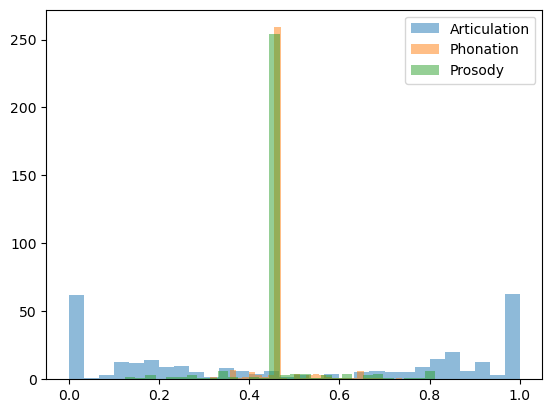

In [ ]:
import matplotlib.pyplot as plt

plt.hist(proba_train_artic, bins=30, alpha=0.5, label='Articulation')
plt.hist(proba_train_phon, bins=30, alpha=0.5, label='Phonation')
plt.hist(proba_train_pros, bins=30, alpha=0.5, label='Prosody')
plt.legend()
plt.show()


# Late fusion

In [ ]:
from ast import literal_eval

def load_and_preprocess_csv(feature_name):
    """Load and preprocess CSV files for a given feature type"""
    df = pd.read_csv(f'{feature_name}_results.csv')
    
    # Convert string representations to actual lists/arrays
    df['y_true'] = df['y_true'].apply(literal_eval)
    
    # Fix for y_pred - handle numpy-style array strings
    def parse_pred(pred_str):
        # Remove brackets and split by whitespace
        cleaned = pred_str.strip('[]').split()
        return np.array([int(x) for x in cleaned if x])
    
    df['y_pred'] = df['y_pred'].apply(parse_pred)
    
    # Handle y_proba - may need similar cleaning
    def parse_proba(proba_str):
        # Remove brackets and split by whitespace
        cleaned = proba_str.strip('[]').split()
        # Handle cases where values are separated by newlines
        cleaned = [x for x in cleaned if x and not x.isspace()]
        return np.array([float(x) for x in cleaned if x])
    
    df['y_proba'] = df['y_proba'].apply(parse_proba)
    df['test_files'] = df['test_files'].apply(literal_eval)
    
    return df

path = 'results_motor_libre/PD_vs_HC/'
features = ['articulation', 'phonation', 'prosody']
feature_dfs = {feature: load_and_preprocess_csv(path+feature) for feature in features}

In [ ]:
feature_dfs['articulation']

,outer_fold,accuracy,sensitivity,specificity,f1,precision,confusion_matrix,y_true,y_pred,y_proba,best_params,train_files,test_files
0,1,0.625000,1.000,0.250000,0.727273,0.571429,[[2 6]\n [0 8]],"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.68465961, 0.47287623, 0.2600975, 0.64586616...","SVC(C=10, gamma=0.01, probability=True, random...","['C001R_AJZP_MOTOR_LIBRE.wav', 'C004_MLQ_MOTOR...","[C003_EMAO_MOTOR_LIBRE.wav, C007_RSL_MOTOR_LIB..."
1,2,0.750000,1.000,0.500000,0.800000,0.666667,[[4 4]\n [0 8]],"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.13511593, 0.32289877, 0.68288235, 0.3658964...","SVC(C=1, gamma=0.01, probability=True, random_...","['C001R_AJZP_MOTOR_LIBRE.wav', 'C003_EMAO_MOTO...","[C004_MLQ_MOTOR_LIBRE.wav, C012_CTRE_MOTOR_LIB..."
2,3,0.625000,0.375,0.875000,0.500000,0.750000,[[7 1]\n [5 3]],"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]","[0.08572172, 0.14284714, 0.28998639, 0.0621633...","SVC(C=1, gamma=0.001, probability=True, random...","['C001R_AJZP_MOTOR_LIBRE.wav', 'C003_EMAO_MOTO...","[C013_JIHL_MOTOR_LIBRE.wav, C015_HJOL_MOTOR_LI..."
3,4,0.937500,0.875,1.000000,0.933333,1.000000,[[8 0]\n [1 7]],"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]","[0.32167863, 0.19599956, 0.20170365, 0.2672609...","SVC(C=10, gamma=0.0001, probability=True, rand...","['C001R_AJZP_MOTOR_LIBRE.wav', 'C002_ARR_MOTOR...","[C005_ABV_MOTOR_LIBRE.wav, C006_JJHN_MOTOR_LIB..."
4,5,0.733333,0.750,0.714286,0.750000,0.750000,[[5 2]\n [2 6]],"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0]","[0.41640186, 0.33637674, 0.34667345, 0.7637742...","SVC(C=1, gamma=0.001, probability=True, random...","['C003_EMAO_MOTOR_LIBRE.wav', 'C004_MLQ_MOTOR_...","[C001R_AJZP_MOTOR_LIBRE.wav, C002_ARR_MOTOR_LI..."


In [ ]:
def evaluate_late_fusion_adaboost(feature_dfs, plot_prefix='fusion_adaboost'):
    """Evaluates late fusion with AdaBoost-style weighting from multiple feature DataFrames."""
    n_folds = len(next(iter(feature_dfs.values())))
    fusion_rows = []

    for i in range(n_folds):
        fold_data = {feature: df.iloc[i] for feature, df in feature_dfs.items()}
        y_trues = [fd['y_true'] for fd in fold_data.values()]
        
        # Verificar que todos los y_true coincidan
        if not all(np.array_equal(y_trues[0], y) for y in y_trues[1:]):
            raise ValueError(f"Mismatch in y_true values at fold {i}")
        
        y_true = np.array(y_trues[0])

        probas = []
        alphas = []

        for fd in fold_data.values():
            y_pred = np.array(fd['y_pred'])
            y_proba = np.array(fd['y_proba'])

            # Calcular tasa de error y alpha estilo AdaBoost
            error = 1 - accuracy_score(y_true, y_pred)
            error = np.clip(error, 1e-10, 1 - 1e-10)
            alpha = 0.5 * np.log((1 - error) / error)

            probas.append(y_proba)
            alphas.append(alpha)

        # Normalizar alphas
        alphas = np.array(alphas)
        alphas /= alphas.sum()

        # Fusionar probabilidades
        probas = np.array(probas)
        fused_proba = np.average(probas, axis=0, weights=alphas)
        fused_pred = (fused_proba >= 0.5).astype(int)

        fold_result = {
            'outer_fold': fold_data[next(iter(fold_data))]['outer_fold'],
            'accuracy': accuracy_score(y_true, fused_pred),
            'sensitivity': recall_score(y_true, fused_pred),
            'specificity': specificity_score(y_true, fused_pred),
            'f1': f1_score(y_true, fused_pred),
            'precision': precision_score(y_true, fused_pred),
            'confusion_matrix': confusion_matrix(y_true, fused_pred),
            'y_true': y_true,
            'y_pred': fused_pred,
            'y_proba': fused_proba
        }
        fusion_rows.append(fold_result)

    fusion_df = pd.DataFrame(fusion_rows)

    # Global metrics
    all_y_true = np.concatenate(fusion_df['y_true'].values)
    all_y_pred = np.concatenate(fusion_df['y_pred'].values)
    all_y_proba = np.concatenate(fusion_df['y_proba'].values)

    overall_metrics = {
        'accuracy': accuracy_score(all_y_true, all_y_pred),
        'sensitivity': recall_score(all_y_true, all_y_pred),
        'specificity': specificity_score(all_y_true, all_y_pred),
        'f1': f1_score(all_y_true, all_y_pred),
        'precision': precision_score(all_y_true, all_y_pred),
        'confusion_matrix': confusion_matrix(all_y_true, all_y_pred)
    }

    # Visualizaciones
    plot_ROC_curve(all_y_true, all_y_proba, filename=f'{plot_prefix}_roc_curve.png')
    plot_confusion_matrix(all_y_true, all_y_pred, filename=f'{plot_prefix}_confusion_matrix.png')
    plot_probability_density(all_y_true, all_y_proba, filename=f'{plot_prefix}_probability_density.png')

    return fusion_df, overall_metrics

fusion_df, metrics = evaluate_late_fusion_adaboost(feature_dfs, plot_prefix='late_fusion_motor_libre')
print(metrics)


{'accuracy': 0.7088607594936709, 'sensitivity': 0.75, 'specificity': 0.6666666666666666, 'f1': 0.7228915662650602, 'precision': 0.6976744186046512, 'confusion_matrix': array([[26, 13],
       [10, 30]], dtype=int64)}


In [ ]:
X_fusion = np.stack([
    np.fromstring(df['y_proba'].iloc[0].strip("[]"), sep=' ')
    for df in csvs.values()
], axis=1)

,outer_fold,accuracy,sensitivity,specificity,f1,precision,confusion_matrix,y_true,y_pred,y_proba,best_params,train_files,test_files
0,1,0.625000,1.000,0.250000,0.727273,0.571429,[[2 6]\n [0 8]],"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]",[1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1],[0.68465961 0.47287623 0.2600975 0.64586616 0...,"SVC(C=10, gamma=0.01, probability=True, random...","['C001R_AJZP_MOTOR_LIBRE.wav', 'C004_MLQ_MOTOR...","['C003_EMAO_MOTOR_LIBRE.wav', 'C007_RSL_MOTOR_..."
1,2,0.750000,1.000,0.500000,0.800000,0.666667,[[4 4]\n [0 8]],"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]",[0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1],[0.13511593 0.32289877 0.68288235 0.36589647 0...,"SVC(C=1, gamma=0.01, probability=True, random_...","['C001R_AJZP_MOTOR_LIBRE.wav', 'C003_EMAO_MOTO...","['C004_MLQ_MOTOR_LIBRE.wav', 'C012_CTRE_MOTOR_..."
2,3,0.625000,0.375,0.875000,0.500000,0.750000,[[7 1]\n [5 3]],"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]",[0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0],[0.08572172 0.14284714 0.28998639 0.06216338 0...,"SVC(C=1, gamma=0.001, probability=True, random...","['C001R_AJZP_MOTOR_LIBRE.wav', 'C003_EMAO_MOTO...","['C013_JIHL_MOTOR_LIBRE.wav', 'C015_HJOL_MOTOR..."
3,4,0.937500,0.875,1.000000,0.933333,1.000000,[[8 0]\n [1 7]],"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]",[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1],[0.32167863 0.19599956 0.20170365 0.26726098 0...,"SVC(C=10, gamma=0.0001, probability=True, rand...","['C001R_AJZP_MOTOR_LIBRE.wav', 'C002_ARR_MOTOR...","['C005_ABV_MOTOR_LIBRE.wav', 'C006_JJHN_MOTOR_..."
4,5,0.733333,0.750,0.714286,0.750000,0.750000,[[5 2]\n [2 6]],"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]",[0 0 0 1 1 0 0 1 1 0 1 1 1 1 0],[0.41640186 0.33637674 0.34667345 0.76377423 0...,"SVC(C=1, gamma=0.001, probability=True, random...","['C003_EMAO_MOTOR_LIBRE.wav', 'C004_MLQ_MOTOR_...","['C001R_AJZP_MOTOR_LIBRE.wav', 'C002_ARR_MOTOR..."


In [22]:
def run_nested_svm_cv(fold_dict, features_df, random_state=42, features='articulation'):
    """
        Perform nested CV SVM classification with predefined folds
        
        Parameters:
        -----------
        fold_dict : dict
            Output from generate_nested_cv_folds()
        features_df : pd.DataFrame
            DataFrame with features (index=filename, columns=features)
        random_state : int
            Random seed for reproducibility
            
        Returns:
        --------
        tuple: (results_df, all_y_true, all_y_pred, all_y_proba)
    """

    C = []
    gamma = []
    score = []
    results = []
    test_predictions = []

    for outer_fold, fold_info in fold_dict.items():
        test_ids = [id_ + '_MOTOR_LIBRE.wav' for id_ in fold_info["test"].keys()]
        y_test = list(fold_info["test"].values())

        train_labels_dict = {}
        for inner in fold_info["inner"].values():
            train_labels_dict.update(inner["train"])
            train_labels_dict.update(inner["val"])
        train_ids = [id_ + '_MOTOR_LIBRE.wav' for id_ in train_labels_dict.keys()]
        y_train = list(train_labels_dict.values())

        X_train = features_df.loc[train_ids].values
        X_test = features_df.loc[test_ids].values

        inner_folds = []
        for inner_num, inner in fold_info["inner"].items():
            inner_train_ids = [id_ + '_MOTOR_LIBRE.wav' for id_ in inner["train"].keys()]
            val_ids = [id_ + '_MOTOR_LIBRE.wav' for id_ in inner["val"].keys()]
            train_idx = [i for i, id_ in enumerate(train_ids) if id_ in inner_train_ids]
            val_idx = [i for i, id_ in enumerate(train_ids) if id_ in val_ids]
            inner_folds.append((train_idx, val_idx))

        model = train_randomized_inner_model(X_train, y_train, inner_folds, random_state)

        print("--------------- Best Params ------------------")
        print(model.best_params_)
        print(model.best_score_)
        C.append(model.best_params_['C'])
        gamma.append(model.best_params_['gamma'])
        score.append(model.best_score_)
    
    print(C, gamma)
    Copt=np.median(C)
    gammaopt=np.median(gamma)
    print(Copt, gammaopt)
    print('-----------------------------------------')
    print()

    for idx, (outer_fold, fold_info) in enumerate(fold_dict.items()):
        test_ids = [id_ + '_MOTOR_LIBRE.wav' for id_ in fold_info["test"].keys()]
        y_test = list(fold_info["test"].values())

        train_labels_dict = {}
        for inner in fold_info["inner"].values():
            train_labels_dict.update(inner["train"])
            train_labels_dict.update(inner["val"])
        train_ids = [id_ + '_MOTOR_LIBRE.wav' for id_ in train_labels_dict.keys()]
        y_train = list(train_labels_dict.values())

        X_train = features_df.loc[train_ids].values
        X_test = features_df.loc[test_ids].values

        scaler=StandardScaler()
        X_train=scaler.fit_transform(X_train)
        X_test=scaler.transform(X_test)

        model = SVC(C=Copt, gamma=gammaopt, kernel="rbf", random_state=random_state, probability=True)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        score = model.decision_function(X_test)

        acc = accuracy_score(y_test, y_pred)
        sens = recall_score(y_test, y_pred)
        spec = specificity_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        results.append({
            'outer_fold': outer_fold,
            'accuracy': acc,
            'sensitivity': sens,
            'specificity': spec,
            'f1': f1,
            'precision': prec,
            'confusion_matrix': cm,
            'C': C[idx],
            'gamma': gamma[idx]
        })

        for sample_id, yt, yp, yp_prob, sc in zip(test_ids, y_test, y_pred, y_proba, score):
            test_predictions.append({
                'id': sample_id,
                'y_true': yt,
                'y_pred': yp,
                'y_proba': yp_prob,
                'score': sc,
                'outer_fold': outer_fold
            })

        print(f"\nFold {outer_fold} Results:")
        print(f"Train set size: {len(y_train)}")
        print(f"Test set size: {len(y_test)}")
        print(f"Accuracy: {acc:.3f}")
        print(f"Sensitivity: {sens:.3f}")
        print(f"Specificity: {spec:.3f}")

    return results, test_predictions

In [24]:
with open("folds/CTR_DCL_vs_Park_DCL_folds.json", "r") as f:
    fold_dict = json.load(f)

In [25]:
features_artic = pd.read_csv(f'features_motor_libre/articulationfeatures_ML.csv').set_index('id')
featuress_phonation = pd.read_csv(f'features_motor_libre/phonationfeatures_ML.csv').set_index('id')
featuress_phonological = pd.read_csv(f'features_motor_libre/phonologicalfeatures_ML.csv').set_index('id')

# For articulation
results, test_predictions = run_nested_svm_cv(fold_dict, featuress_phonological, features='phonological')
results = pd.DataFrame(results)
test_predictions = pd.DataFrame(test_predictions)

results = results[['outer_fold', 'accuracy', 'sensitivity', 'specificity', 'f1', 'C', 'gamma']]

features='phonological'
plot_ROC_curve(test_predictions['y_true'], test_predictions['y_proba'], f'results_motor_libre/plots/roc_curve_{features}.png')
plot_confusion_matrix(test_predictions['y_true'], test_predictions['y_pred'], f'results_motor_libre/plots/confusion_matrix_{features}.png')
plot_probability_density(test_predictions['y_true'], test_predictions['y_proba'], f'results_motor_libre/plots/probability_density_{features}.png')

Fitting 4 folds for each of 72 candidates, totalling 288 fits
Initial best C from GridSearch: 10
Initial best gamma from GridSearch: 0.001
Fitting 4 folds for each of 1000 candidates, totalling 4000 fits
Final best params from RandomizedSearch:
{'C': 17.86429543354675, 'gamma': 0.000238687625248947, 'kernel': 'rbf'}
Final best score: 0.9583333333333334
--------------- Best Params ------------------
{'C': 17.86429543354675, 'gamma': 0.000238687625248947, 'kernel': 'rbf'}
0.9583333333333334
Fitting 4 folds for each of 72 candidates, totalling 288 fits
Initial best C from GridSearch: 10
Initial best gamma from GridSearch: 0.001
Fitting 4 folds for each of 1000 candidates, totalling 4000 fits
Final best params from RandomizedSearch:
{'C': 6.08934687859775, 'gamma': 0.001537936011030912, 'kernel': 'rbf'}
Final best score: 0.9583333333333334
--------------- Best Params ------------------
{'C': 6.08934687859775, 'gamma': 0.001537936011030912, 'kernel': 'rbf'}
0.9583333333333334
Fitting 4 fold

In [21]:
test_predictions = pd.DataFrame(test_predictions)
test_predictions

,id,y_true,y_pred,y_proba,score,outer_fold
0,C001R_AJZP_MOTOR_LIBRE.wav,0,1,0.699825,0.195661,1
1,C003_EMAO_MOTOR_LIBRE.wav,0,0,0.054226,-1.134807,1
2,C017_JMLC_MOTOR_LIBRE.wav,0,1,0.619471,0.065575,1
3,C046_GGC_MOTOR_LIBRE.wav,0,0,0.019305,-1.505567,1
4,P003_MBCB_MOTOR_LIBRE.wav,1,1,0.758533,0.301508,1
5,P019_EAS_MOTOR_LIBRE.wav,1,1,0.987108,1.435205,1
6,P044_CHBB_MOTOR_LIBRE.wav,1,1,0.681517,0.165232,1
7,C005_ABV_MOTOR_LIBRE.wav,0,0,0.188860,-0.706179,2
8,C020_JEG_MOTOR_LIBRE.wav,0,1,0.542992,0.006389,2
9,C050_BOLR_MOTOR_LIBRE.wav,0,0,0.048594,-1.386522,2


In [ ]:
results

,outer_fold,accuracy,sensitivity,specificity,f1,C,gamma
0,1,0.714286,1.000000,0.500000,0.75,17.864295,0.000239
1,2,0.714286,0.750000,0.666667,0.75,6.089347,0.001538
2,3,1.000000,1.000000,1.000000,1.00,13.167457,0.009129
3,4,0.833333,0.666667,1.000000,0.80,2.530821,0.003303
4,5,1.000000,1.000000,1.000000,1.00,1.475215,0.000769
